# Disaggregation

In [1]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation

/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/scipy/linalg/__init__.py:191: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-p

### Dividing data into train and test set

In [2]:
train = DataSet('/home/shifona/Downloads/mini_project/REDD/redd.h5')
test = DataSet('/home/shifona/Downloads/mini_project/REDD/redd.h5')

/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/tables/__init__.py:90: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .utilsextension import (
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/tables/file.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import hdf5extension
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/tables/link.py:33: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import linkextension
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/tables/table.py:28: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import tableextension
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/tables/index.py:33: RuntimeWarning: numpy.dtype size changed, may indicate binar

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 586, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1305, in H5F_open
    unable to lock the file
  File "H5FD.c", line 1839, in H5FD_lock
    driver lock request failed
  File "H5FDsec2.c", line 940, in H5FD_sec2_lock
    unable to lock file, errno = 11, error message = 'Resource temporarily unavailable'

End of HDF5 error back trace

Unable to open/create file '/home/shifona/Downloads/mini_project/REDD/redd.h5'

Let us use building 1 for demo purposes

In [3]:
building = 1

Let's split data at April 30th

In [4]:
# train.set_window(end="24-4-2011")
# test.set_window(start="30-4-2011")


train_elec = train.buildings[2].elec
test_elec = test.buildings[2].elec

NameError: name 'train' is not defined

In [5]:
train_elec.plot()

NameError: name 'train_elec' is not defined

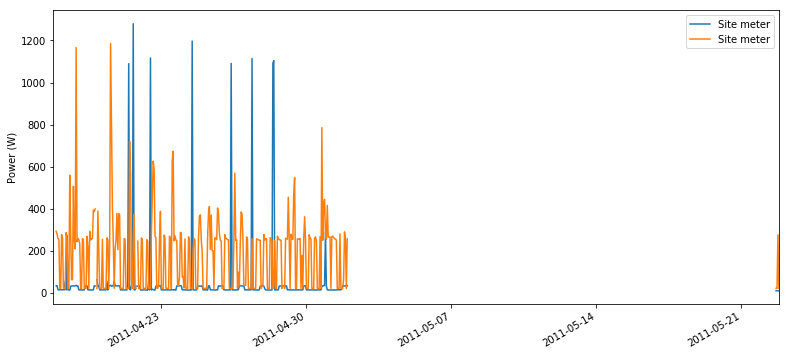

In [6]:
test_elec.mains().plot()

REDD data set has got appliance level data sampled every 3 or 4 seconds and mains data sampled every 1 second. Let us verify the same.

In [7]:
fridge_meter = train_elec['fridge']

In [8]:
fridge_df = fridge_meter.load().next()

In [9]:
fridge_df.head()

physical_quantity,power
type,active
2011-04-18 01:31:40-04:00,6.0
2011-04-18 01:31:44-04:00,6.0
2011-04-18 01:31:47-04:00,6.0
2011-04-18 01:31:50-04:00,7.0
2011-04-18 01:32:05-04:00,7.0


In [10]:
mains = train_elec.mains()

In [11]:
mains_df = mains.load().next()

Loading data for meter ElecMeterID(instance=1, building=2, dataset='REDD')     

/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/nilmtk/utils.py:336: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  return resampled.index[0]
/home/shifona/anaconda2/envs/nilmtk/lib/python2.7/site-packages/nilmtk/utils.py:390: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=30)
  data = data.resample(**resample_kwargs)


Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.


In [12]:
mains_df.head()

physical_quantity,power
type,apparent
2011-04-17 19:18:27-04:00,306.809998
2011-04-17 19:18:28-04:00,306.319977
2011-04-17 19:18:29-04:00,306.400024
2011-04-17 19:18:30-04:00,305.760010
2011-04-17 19:18:31-04:00,321.360016


Since, both of these are sampled at different frequencies, we will downsample both to 1 minute resolution. We will also select the top-5 appliances in terms of energy consumption and use them for training our FHMM and CO models.

### Selecting top-5 appliances

In [16]:
top_5_train_elec = train_elec.submeters().select_top_k(k=1)

9/9 ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])

In [17]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
)

### Training and disaggregation

#### FHMM

In [20]:
start = time.time()
from nilmtk.disaggregate import fhmm_exact,hart_85, combinatorial_optimisation
fhmm = fhmm_exact.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute. 
# If instead of top_5 we wanted to train on all appliance, we would write 
# fhmm.train(train_elec, sample_period=60)
fhmm.train(top_5_train_elec, sample_period=60)
hart = combinatorial_optimisation.CombinatorialOptimisation()
#hart = hart_85.Hart85()
hart.train(top_5_train_elec)

end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Done training!
Runtime = 3.31008601189 seconds.


In [21]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load(sample_period=60)):
    chunk_drop_na = chunk.dropna()
    pred[i] = fhmm.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = meter.load(sample_period=60).next()
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()

pred2 = {}
gt2= {}

for i, chunk in enumerate(test_elec.mains().load()):
    chunk_drop_na = chunk.dropna()
    pred2[i] = hart.disaggregate_chunk(chunk_drop_na)
    gt2[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt2[i][meter] = meter.load().next()
    gt2[i] = pd.DataFrame({k:v.squeeze() for k,v in gt2[i].iteritems()}, index=gt2[i].values()[0].index).dropna()

Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'


In [22]:
# If everything can fit in memory
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

print(pred_overall.columns)
print("********")
print(gt_overall.columns)

# Having the same order of columns
gt_overall = gt_overall[pred_overall.columns]

# If everything can fit in memory
gt_overall2 = pd.concat(gt2)
gt_overall2.index = gt_overall2.index.droplevel()
pred_overall2 = pd.concat(pred2)
pred_overall2.index = pred_overall2.index.droplevel()

print(pred_overall2.columns)
print("********")
print(gt_overall2.columns)

# Having the same order of columns
gt_overall2 = gt_overall2[pred_overall2.columns]

Index([ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])], dtype='object')
********
Index([               ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)]),
             ElecMeter(instance=5, building=2, dataset='REDD', appliances=[Appliance(type='electric stove', instance=1)]),
                    ElecMeter(instance=3, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)]),
                  ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)]),
                     ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)]),
               ElecMeter(instance=7, building=2, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)]),
                    ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)]),
    

In [23]:
#Intersection of index
gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)

In [24]:
local_timezone = train.metadata['timezone']

In [25]:
common_index_local = common_index_utc.tz_convert(local_timezone)

In [26]:
gt_overall = gt_overall.ix[common_index_local]
pred_overall = pred_overall.ix[common_index_local]

gt_overall2 = gt_overall2.ix[common_index_local]
pred_overall2 = pred_overall.ix[common_index_local]

In [27]:
gt_overall.head()

,"ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])"
2011-04-18 01:32:00-04:00,7.0
2011-04-18 01:33:00-04:00,6.0
2011-04-18 01:34:00-04:00,7.0
2011-04-18 01:35:00-04:00,6.0
2011-04-18 01:36:00-04:00,6.0


In [28]:
gt_overall2.head()

,"ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])"
2011-04-18 01:32:00-04:00,NaN
2011-04-18 01:33:00-04:00,6.0
2011-04-18 01:34:00-04:00,7.0
2011-04-18 01:35:00-04:00,NaN
2011-04-18 01:36:00-04:00,NaN


Using prettier names!

In [29]:
appliance_labels = [m.label() for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels
pred_overall.columns = appliance_labels

In [34]:
appliance_labels = [m.label() for m in gt_overall2.columns.values]
gt_overall2.columns = appliance_labels
pred_overall2.columns = appliance_labels

In [35]:
pred_overall.head()

,Fridge
2011-04-18 01:32:00-04:00,6.0
2011-04-18 01:33:00-04:00,6.0
2011-04-18 01:34:00-04:00,6.0
2011-04-18 01:35:00-04:00,6.0
2011-04-18 01:36:00-04:00,6.0


In [36]:
pred_overall2.head()

,Fridge
2011-04-18 01:32:00-04:00,6.0
2011-04-18 01:33:00-04:00,6.0
2011-04-18 01:34:00-04:00,6.0
2011-04-18 01:35:00-04:00,6.0
2011-04-18 01:36:00-04:00,6.0


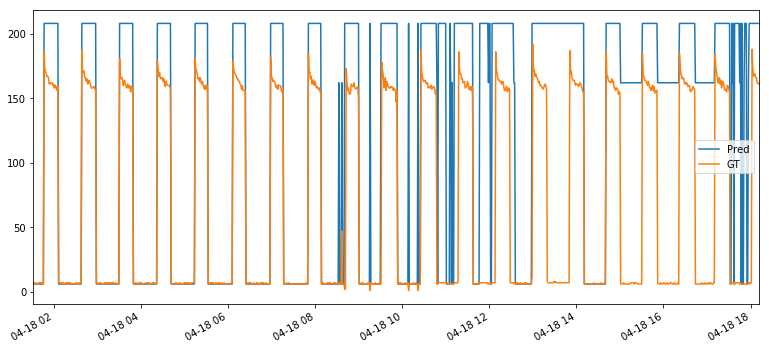

In [37]:
pred_overall['Fridge'].head(1000).plot(label="Pred")
gt_overall['Fridge'].head(1000).plot(label="GT")
plt.legend()

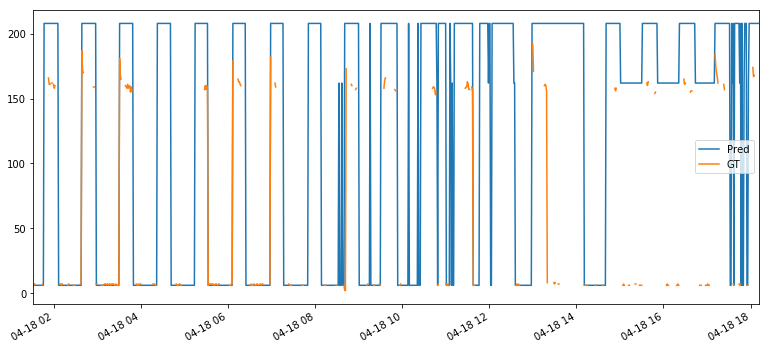

In [38]:
pred_overall2['Fridge'].head(1000).plot(label="Pred")
gt_overall2['Fridge'].head(1000).plot(label="GT")
plt.legend()

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
rms_error = {}
for appliance in gt_overall.columns:
    rms_error[appliance] = np.sqrt(mean_squared_error(gt_overall[appliance], pred_overall[appliance]))

In [41]:
pd.Series(rms_error)

Fridge    79.796821
dtype: float64

In [42]:
import math
pd_ = {}
gt_ = {}
rerror = {}
lt = 0
leng = {}
napp = []
#print(gt_overall.columns)
for appliance in gt_overall.columns:
    t = len(pred_overall[appliance])
    if lt<t:
        lt = t
        napp = []
    if lt==t:
        napp.append(appliance)
    leng[appliance]= t
    print(str(appliance) + " : "+str(t))
    

for appliance in napp:
    if (leng[appliance] < lt):
        continue
    print(appliance)
    gt_[appliance] = gt_overall[appliance]
    pd_[appliance] = pred_overall[appliance]
    #print(gt_[appliance])
    #for a,b in zip(pred_overall[appliance],gt_overall[appliance]):
    #    pd[appliance].append(a)
    #    gt[appliance].append(b)
   # print gt_[appliance][1]
    print(str(len(pd_[appliance]))+", "+str(len(gt_[appliance])))
    #print(str(len(pred_overall[appliance]))+": "+str(len(gt_overall[appliance])))
    
print(napp)
print(lt)
s = 0
sd = 0
for i in range(lt):
    for appliance in napp:
        #if isinstance( pd[appliance][0], ( int, long ) ):
        #print( pd_[appliance] )
        #print(i)
        s = s + abs(pd_[appliance][i]-gt_[appliance][i])
        sd = sd + gt_[appliance][i]
        
acc = 1 - (1.0*s)/sd/2
print(acc)
#print(pd)


Fridge : 20033
Fridge
20033, 20033
['Fridge']
20033
0.709087952975


In [43]:
import math
pd_ = {}
gt_ = {}
rerror = {}
lt = 0
leng = {}
napp = []
#print(gt_overall.columns)
for appliance in gt_overall2.columns:
    t = len(pred_overall2[appliance])
    if lt<t:
        lt = t
        napp = []
    if lt==t:
        napp.append(appliance)
    leng[appliance]= t
    print(str(appliance) + " : "+str(t))
    

for appliance in napp:
    if (leng[appliance] < lt):
        continue
    print(appliance)
    gt_[appliance] = gt_overall2[appliance]
    pd_[appliance] = pred_overall2[appliance]
    #print(gt_[appliance])
    #for a,b in zip(pred_overall[appliance],gt_overall[appliance]):
    #    pd[appliance].append(a)
    #    gt[appliance].append(b)
   # print gt_[appliance][1]
    print(str(len(pd_[appliance]))+", "+str(len(gt_[appliance])))
    #print(str(len(pred_overall[appliance]))+": "+str(len(gt_overall[appliance])))
    
print(napp)
print(lt)
s = 0
sd = 0
for i in range(lt):
    for appliance in napp:
        #if isinstance( pd[appliance][0], ( int, long ) ):
        #print( pd_[appliance] )
        #print(i)
        s = s + abs(pd_[appliance][i]-gt_[appliance][i])
        sd = sd + gt_[appliance][i]
        
acc = 1 - (1.0*s)/sd/2
print(acc)
#print(pd)


Fridge : 20033
Fridge
20033, 20033
['Fridge']
20033
nan
